In [1]:
# TODO change to mcnemar pvalue
# NOTE: real tests (McNemar) done in R notebook
# TODO 2nd round where only look at mutations to rare things

In [2]:
# scratch
#import scipy.stats
#t = 783123
#n11 = 2211
#n21 = 2104
#t = 26018
#n11 = 73
#n21 = 44
#n12 = t-n11
#n22 = t-n21
#table = [[n11, n12], [n21, n22]]
#scipy.stats.fisher_exact(table, alternative="greater")

In [3]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os
import pandas as pd
import scipy.stats

# Params
PTHRESH=0.8
PCOLORS = {
    "ALL": "black",
    1: "gray",
    2: "red",
    3: "gold",
    4: "blue",
    5: "green",
    6: "purple"
}
PLABELS = {
    "ALL": "ALL",
    1: "Mono-",
    2: "Di-",
    3: "Tri-",
    4: "Tetra-",
    5: "Penta-",
    6: "Hexa-"
}

# Load data
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls_filtered/"
annot = pd.read_csv("/storage/mgymrek/ssc-denovos/denovos2/denovocalls/annotations/denovo_annotations.bed", sep="\t")
data = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary.bed.gz"), sep="\t", usecols=range(18))
data = data[data["total_mutations"]>0]
data = pd.merge(data, annot, on=["start","end"])
for i in range(2, 7): # sfari cols include higher annotations
    data["sfari%s"%i] = data["sfari%s"%i] + data["sfari%s"%(i-1)]
    
# Outputs
OUTPATH = "pdfs"
PREFIX = "Figure3"

Populating the interactive namespace from numpy and matplotlib


In [4]:
data.to_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary_annotated.bed"), sep="\t", index=False)

data_rare = pd.read_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary_rare.bed.gz"), sep="\t", usecols=range(18))
data_rare = data_rare[data_rare["total_mutations"]>0]
data_rare = pd.merge(data_rare, annot, on=["start","end"])
for i in range(2, 7): # sfari cols include higher annotations
    data_rare["sfari%s"%i] = data_rare["sfari%s"%i] + data_rare["sfari%s"%(i-1)]
data_rare.to_csv(os.path.join(RESDIR, "denovos_bylength.locus_summary_annotated_rare.bed"), sep="\t", index=False)

In [5]:
data_rare[data_rare["GATAD2B"]>=1].sort("p-value")

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,#chrom,start,end,period,total_children,total_mutations,total_mutation_rate,affected_children,affected_mutations,affected_new_mutations,...,ZEB1,ZNF143,ZNF207,ZNF217,ZNF24,ZNF384,ZNF592,ZNF687,ZSCAN29,ZZZ3
4487,9,110802912,110802929.0,1,370,2,0.005405,185,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3968,8,36739315,36739362.0,2,906,2,0.002208,453,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6129,14,69407395,69407412.0,1,934,1,0.001071,467,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,1,200873219,200873234.0,1,864,1,0.001157,432,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7038,17,75188746,75188757.0,1,942,1,0.001062,471,1,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1150,2,186996419,186996430.0,1,942,1,0.001062,471,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2551,5,56406491,56406503.0,1,936,1,0.001068,468,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4098,8,80286386,80286416.0,2,936,1,0.001068,468,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,1,245950014,245950028.0,1,944,1,0.001059,472,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
612,2,3462278,3462308.0,2,942,1,0.001062,471,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [6]:
TFs = ["ARID3A", "ATF2", "ATF7", "BACH1", "BATF", "BCL11A", "BCLAF1", "BHLHE40", "BMI1", "BRCA1", "CBFB", "CBX3", "CBX5", "CBX8", "CEBPB", "CEBPZ", "CHD1", "CHD2", "CHD4", "CHD7", "CREM", "CTBP1", "CTCF", "CUX1", "DPF2", "E2F4", "EBF1", "EED", "EGR1", "ELF1", "ELK1", "EP300", "ESRRA", "ETV6", "FOS", "FOXK2", "GABPA", "GATAD2B", "HCFC1", "HDAC2", "HDGF", "HSF1", "IKZF1", "IKZF2", "IRF3", "IRF5", "JUNB", "JUND", "KDM1A", "KDM5A", "MAFK", "MAX", "MAZ", "MEF2C", "MLLT1", "MTA2", "MTA3", "MXI1", "MYB", "MYC", "NBN", "NFE2", "NFIC", "NFXL1", "NFYA", "NFYB", "NR2C1", "NR2C2", "NR2F1", "NRF1", "PKNOX1", "POLR2A", "POLR2AphosphoS2", "POLR2AphosphoS5", "POLR3G", "RAD21", "RAD51", "RB1", "RBBP5", "RCOR1", "RELB", "REST", "RFX5", "RUNX3", "SIN3A", "SKIL", "SMAD5", "SMARCA5", "SMC3", "SP1", "SPI1", "SRF", "STAT1", "STAT3", "TAF1", "TARDBP", "TBL1XR1", "TBP", "TBX21", "TCF12", "TCF7", "TRIM22", "UBTF", "USF1", "USF2", "WHSC1", "WRNIP1", "YBX1", "YY1", "ZBED1", "ZBTB40", "ZEB1", "ZNF143", "ZNF207", "ZNF217", "ZNF24", "ZNF384", "ZNF592", "ZNF687", "ZSCAN29", "ZZZ3"]

In [7]:
def GetASDEnrichment(df, printit=False):
    t = sum(df["total_children"])/2
    n11 = sum(df["affected_mutations"])
    n12 = t - n11
    n21 = sum(df["unaffected_mutations"])
    n22 = t - n21
    table = [[n11, n12], [n21, n22]]
    if printit:
        print(table)
    x = scipy.stats.fisher_exact(table, alternative="greater")
    if printit:
        print(str(x))
    return np.log2(x[0]), -1*np.log10(x[1])

def GetCaseCtrlFreq(df):
    """
    Return [ctrl freq of denovo alleles from ctrls], [ctrl freq of denovo alleles from cases]
    Use count rather than freq since can't exactly get the denominator from here (bc of filtering)
    """
    ctrl_freqs = []
    case_freqs = []
    for i in range(df.shape[0]):
        items = df["children_with_mutations"].values[i].split(",")
        #pardenom = df["total_children"].values[i]/2*4*2 # 2 children/family, 4 parents per family, 2 alleles per parent
        for i in range(int(len(items)/3+1)):
            mutitem = (items[i*3:i*3+3])
            if len(mutitem)==0: continue
            status = mutitem[0].split(":")[1]
            parcount = int(mutitem[-1])
            freq = parcount  #*1.0/(pardenom)
            if status == "2": case_freqs.append(freq)
            else: ctrl_freqs.append(freq)
    return ctrl_freqs, case_freqs

def GetRareAlleleEnrich(df, count=5):
    ctrl_freqs, case_freqs = GetCaseCtrlFreq(df)
    n_ctrl_rare = len([item for item in ctrl_freqs if item <= count])
    n_ctrl_common = len(ctrl_freqs) - n_ctrl_rare
    n_case_rare = len([item for item in case_freqs if item <= count])
    n_case_common = len(case_freqs) - n_case_rare
    t = [[n_ctrl_rare, n_ctrl_common], [n_case_rare, n_case_common]]
    return scipy.stats.fisher_exact(t, alternative="less")[1]

# Figure 3A QQ plot

In [8]:
def GetPermP(x):
    t = x["total_children"]
    if x["total_mutations"] == 0:
        n_aff = 0
        n_unaff = 0
    else:
        nsample = x["total_mutations"]
        n_aff = np.random.hypergeometric(t/2, t/2, nsample)
        n_unaff = nsample - n_aff
    n11 = n_aff
    n12 = t - n_aff
    n21 = n_unaff
    n22 = t - n21
    table = [[n11, n12], [n21, n22]]
    return scipy.stats.fisher_exact(table, alternative="greater")[1]
    
data["perm_p"] = data.apply(GetPermP, 1)

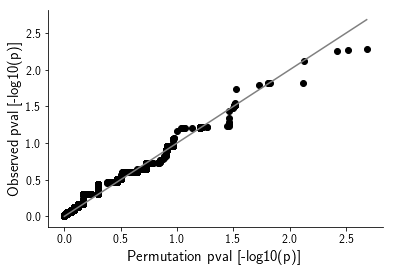

In [9]:
df = data
obs = [-1*np.log10(x) for x in sorted(list(df["p-value"]))]
perm = [-1*np.log10(x) for x in sorted(list(df["perm_p"]))]
exp = [-1*np.log10(x) for x in sorted(np.random.uniform(low=0, high=1, size=len(obs)))]
exp = []

maxval = max(obs + exp + perm)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(exp, obs, color="black")
#ax.scatter(exp, perm, color="gray")
ax.scatter(perm, obs, color="black")
ax.plot([0,maxval],[0,maxval], color="gray")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Permutation pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);
fig.savefig(os.path.join(OUTPATH, "%s_qqplot.png"%(PREFIX)))

# Figure 3B Enrichment by category

In [10]:
motif_counts = data.groupby("motif", as_index=False).agg({"#chrom":len})
motif_counts.columns = ["motif","count"]
motif_counts = motif_counts.sort("count", ascending=False)
motifs = list(motif_counts[motif_counts["count"]>=100]["motif"].values)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [11]:
# Overall and by period
categories = ["ALL"]
odds, p = GetASDEnrichment(data)
pvals = [p]
enrichments = [odds]
pcc = GetRareAlleleEnrich(data)
colors = ["black"]
pccs = [pcc]
for period in range(1, 7):
    categories.append(PLABELS[period])
    odds, p = GetASDEnrichment(data[data["period"]==period])
    pcc = GetRareAlleleEnrich(data[data["period"]==period])
    pvals.append(p)
    enrichments.append(odds)
    colors.append(PCOLORS[period])
    pccs.append(pcc)
# Transcribed
categories.append("Transcribed")
odds, p = GetASDEnrichment(data[data["gene"]!="."]) 
pcc = GetRareAlleleEnrich(data[data["gene"]!="."])
pvals.append(p)
enrichments.append(odds)
colors.append("white")
pccs.append(pcc)

# STRCons Z TODO redo with new scores
categories.append("strconsZ")
odds, p = GetASDEnrichment(data[data.apply(lambda x: x["strconsZ"]!="." and float(x["strconsZ"])<0, 1)])
pcc = GetRareAlleleEnrich(data[data.apply(lambda x: x["strconsZ"]!="." and float(x["strconsZ"])<0, 1)])
pvals.append(p)
enrichments.append(odds)
pccs.append(pcc)
colors.append("cyan")

# Genomic region
for col in ["coding","3utr","5utr","promoter3kb","rnabp","rnabpTARDBP", "tfbs","estrs","introns"]:
    categories.append(col)
    odds, p = GetASDEnrichment(data[data[col]>=1])
    pcc = GetRareAlleleEnrich(data[data[col]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("white")
    pccs.append(pcc)

# SFARI gene score
for col in ["sfari1","sfari2","sfari3","sfari4","sfari5","sfari6","sfariS"]:
    categories.append(col)
    odds, p = GetASDEnrichment(data[data[col]>=1])
    pcc = GetRareAlleleEnrich(data[data[col]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("purple")
    pccs.append(pcc)

# SFARI CNV
categories.append("SFARICNV")
odds, p = GetASDEnrichment(data[data["sfaricnv"]>=1])
pcc = GetRareAlleleEnrich(data[data["sfaricnv"]>=1])
pvals.append(p)
enrichments.append(odds)
colors.append("purple")
pccs.append(pcc)

#for m in motifs:
#    categories.append(m)
#    odds, p = GetASDEnrichment(data[data["motif"]==m])
#    pvals.append(p)
#    enrichments.append(odds)
#    colors.append("brown")

for h in ['H3K27ac', 'H3K27me3','H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K79me2', 'H3K9ac','H4K20me1']:
    categories.append(h)
    odds, p = GetASDEnrichment(data[data[h]>=1])
    pcc = GetRareAlleleEnrich(data[data[h]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("gold")
    pccs.append(pcc)

for tf in TFs:
    categories.append(tf)
    odds, p = GetASDEnrichment(data[data[tf]>=1])
    pcc = GetRareAlleleEnrich(data[data[tf]>=1])
    pvals.append(p)
    enrichments.append(odds)
    colors.append("blue")
    pccs.append(pcc)
    
categories.append("donor")
odds, p = GetASDEnrichment(data[(data["donor"]>0) & (data["donor"]<100)])
pcc = GetRareAlleleEnrich(data[(data["donor"]>0) & (data["donor"]<100)])
pvals.append(p)
enrichments.append(odds)
colors.append("gold")
pccs.append(pcc)

categories.append("acceptor")
odds, p = GetASDEnrichment(data[(data["acceptor"]<0) & (data["acceptor"]>-100)])
pcc = GetRareAlleleEnrich(data[(data["acceptor"]<0) & (data["acceptor"]>-100)])
pvals.append(p)
enrichments.append(odds)
colors.append("gold")
pccs.append(pcc)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log2


/usr/lib64/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


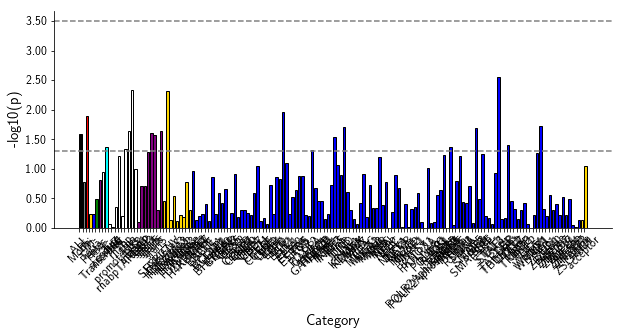

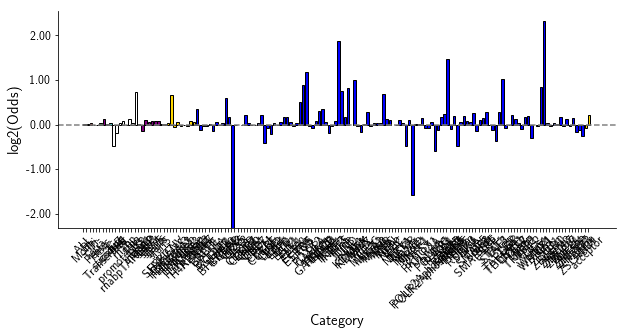

In [12]:
size = (10, 4)
fig = plt.figure()
fig.set_size_inches(size)
ax = fig.add_subplot(111)
ax.bar(range(len(categories)), pvals, color=colors, edgecolor="black", align="edge");
ax.axhline(-1*np.log10(0.05), color="gray", linestyle="dashed");
ax.axhline(-1*np.log10(0.05/len(categories)), color="gray", linestyle="dashed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Category", size=15)
ax.set_ylabel("-log10(p)", size=15)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45)
ax.set_yticklabels(["%0.2f"%x for x in ax.get_yticks()], size=12);
ax.legend(loc="upper right", frameon=False)

fig = plt.figure() 
fig.set_size_inches(size)
ax = fig.add_subplot(111)
ax.bar(range(len(categories)), enrichments, color=colors, edgecolor="black", align="edge");
ax.axhline(0, color="gray", linestyle="dashed");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Category", size=15)
ax.set_ylabel("log2(Odds)", size=15)
#ax.set_ylim(bottom=-0.25, top=-0.25)
#ax.set_yticks(np.arange(-0.25, 0.26, 0.05))
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, size=12, rotation=45)
ax.set_yticklabels(["%0.2f"%(x) for x in ax.get_yticks()], size=12);

In [13]:
edata = pd.DataFrame(
    {
        "category": categories,
        "pval": pvals,
        "enrich": enrichments,
        "pcc": pccs,
    }
)
#edata.sort("pval", ascending=True)
edata[edata["category"]=="3utr"]

,category,enrich,pcc,pval
10,3utr,-0.197234,0.723197,0.009421


In [14]:
data["chrom"] = data["chrom"].apply(int)
#data[data["TARDBP"]>0].sort("p-value")[["chrom","start","end","motif","p-value","children_with_mutations"]]
data[data["estrs"]>0].sort("p-value")[["chrom","start","end","motif","p-value","children_with_mutations"]]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,chrom,start,end,motif,p-value,children_with_mutations
19397,5,39075387,39075454,AC,0.036089,"14498:2:6:30,30,59,14315:2:-6:24,24,44,13732:2..."
1007,1,40203639,40203665,AC,0.108601,"14444:2:28:2,3,3,14291:2:24:56,47,105,13576:1:..."
59442,20,62653342,62653369,AC,0.123919,"14586:2:-8:17,10,34,14261:2:-4:9,9,13,13169:2:..."
33772,9,71472872,71472907,AAC,0.249687,"12582:2:21:3,2,5,11474:2:12:149,141,294"
40111,11,78168844,78168890,AC,0.249708,"14316:2:4:5,6,6,11711:2:2:27,27,54"
3439,1,181025501,181025539,AAT,0.249712,"14249:2:6:122,118,233,14061:2:9:13,17,30"
44398,12,133205231,133205275,AAAAC,0.249723,"13028:2:0:323,324,621,11544:2:-25:435,455,927"
53683,17,48848150,48848177,AAAT,0.249735,"12252:2:12:192,185,375,11653:2:12:192,185,375"
39942,11,71910931,71910977,AC,0.500000,"13444:2:-6:24,17,52"
50164,15,90773150,90773172,ATCCC,0.500000,"11378:2:0:492,497,978"


In [29]:
#data_rare[data_rare["strconsDIFF"].apply(lambda x: x!="." and float(x)<-5)].sort("p-value")[["chrom","start","end","motif","affected_mutations","unaffected_mutations","p-value","strconsZ","strconsDIFF","gene","children_with_mutations"]]
data_rare[data_rare["affected_mutations"]>=2].sort("p-value")[["chrom","start","end","motif","strconsDIFF","affected_mutations","unaffected_mutations","p-value","gene","children_with_mutations"]]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,chrom,start,end,motif,strconsDIFF,affected_mutations,unaffected_mutations,p-value,gene,children_with_mutations
1344,3.0,10317433,10317465.0,AAAAC,0.7398605097859488,3,0,0.124569,TATDN2,"13577:2:3:8,7,6;12852:2:3:8,7,6;11946:2:3:8,7,6"
6950,17.0,55776254,55776302.0,AC,3.40592980321837,4,1,0.185580,.,"14629:2:-16:8,5,7;14547:2:-20:2,7,5;13948:2:-2..."
5031,11.0,30368601,30368621.0,A,-1.0500205893109429,2,0,0.247706,.,"11390:2:1:2,4,8;11328:2:-2:3,8,10"
3313,6.0,128940300,128940318.0,A,.,2,0,0.248848,.,"13076:2:3:1,7,7;13028:2:3:1,7,7"
4230,8.0,128592131,128592151.0,A,-0.7406733321900953,2,0,0.248858,.,"14645:2:1:4,8,10;13290:2:1:4,8,10"
4487,9.0,110802912,110802929.0,A,.,2,0,0.249322,.,"13891:2:3:1,3,2;13575:2:3:1,3,2"
3589,7.0,52058834,52058852.0,A,.,2,0,0.249406,.,"13724:2:5:1,3,5;13687:2:5:1,3,5"
6097,14.0,61647659,61647679.0,A,0.9712194610661273,2,0,0.249448,.,"13947:2:-4:2,5,5;11645:2:-9:2,5,6"
6618,16.0,53798388,53798408.0,A,1.0335284895636416,2,0,0.249460,FTO,"13116:2:9:2,8,5;12572:2:9:2,8,5"
6224,15.0,22506930,22506947.0,A,.,2,0,0.249480,.,"14315:2:-2:0,2,2;13732:2:2:5,8,8"


In [16]:
data[data["sfari6"]>=1].sort("p-value")[["chrom","start","end","motif","affected_mutations","unaffected_mutations","p-value","gene"]]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,chrom,start,end,motif,affected_mutations,unaffected_mutations,p-value,gene
18746,5,9036072,9036092,A,9,2,0.029804,SEMA5A
35303,9,133386511,133386522,A,5,0,0.030836,.
38131,10,117716514,117716534,A,4,0,0.060807,.
8633,2,173915486,173915503,A,4,0,0.061205,RAPGEF4
31048,8,61469201,61469221,A,6,1,0.061412,RAB2A
31962,8,103258233,103258250,A,4,0,0.061606,UBR5-AS1
29784,8,1367608,1367641,AC,4,0,0.061610,DLGAP2
28519,7,103502857,103502915,AGAT,6,1,0.061708,RELN
2923,1,156824969,156825003,AGAT,7,2,0.088740,"INSRR,NTRK1"
11058,3,38048892,38048939,AC,5,1,0.108414,.


In [17]:
#data[data["5utr"]>=1].sort("p-value")[["chrom","start","end","motif","affected_mutations","unaffected_mutations","p-value","gene","strconsDIFF","strconsZ"]]
data[data["start"]==40203639]["children_with_mutations"].values[0]

'14444:2:28:2,3,3,14291:2:24:56,47,105,13576:1:30:4,1,2,12759:2:20:99,89,182,11839:2:24:56,47,105,11653:2:6:62,66,128'